In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)



In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
from src.emfiles import get_data_from_df
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
import mrcfile
from skimage.measure import block_reduce

### Read the data

In [3]:
data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
star_file = "job550_particles_roy40k.star"

#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"


#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

df = star.parse_star(data_dir + star_file, keep_index = False)

imgs, pixel_size, angles, shifts, ctf_params = get_data_from_df(df, data_dir)



/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


In [4]:
#imgs_orig = imgs

print(imgs.shape)
print(pixel_size.shape)
print(angles.shape)
print(shifts.shape)
print(ctf_params.shape)

(39972, 308, 308)
(39972,)
(39972, 3)
(39972, 2)
(39972, 9)


In [5]:
imgs.shape

(39972, 308, 308)

In [6]:
angles

array([[ 1.03457507,  2.2863598 , -2.96771267],
       [-1.40340529,  1.67858889, -1.30280992],
       [-2.18046027,  1.29830161,  2.34853639],
       ...,
       [-0.29634539,  2.47136648, -2.89668036],
       [-1.72064962,  2.095372  , -1.2764858 ],
       [-2.59972805,  1.22137734,  2.04842599]])

In [7]:
shifts[4000:4010,:]

array([[  1.97232698,  12.03521677],
       [ -5.43396052,  -4.9509426 ],
       [  3.82389802,  -3.0993699 ],
       [ -9.2176074 , -17.67043635],
       [  9.29811135,   3.82389802],
       [ -0.92578552,  18.07295198],
       [-11.7937074 , -10.8276699 ],
       [ 18.95848552,  -0.5232699 ],
       [ -0.60377302,   4.22641448],
       [  5.19245115, -19.28049885]])

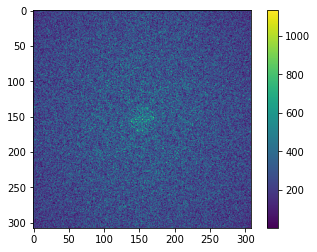

In [8]:
nx = 64
imgs_f = np.fft.fft2(imgs)
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101]))); plt.colorbar()

In [9]:
mid = imgs.shape[-1]/2

imgs_f_cropped = np.zeros([imgs_f.shape[0], nx,nx], dtype = np.complex64)
for i, f in enumerate(imgs_f):
    #img = np.fft.fft2(f)


    #print(f.shape)
    img = np.fft.fftshift(f)
    imgs_f_cropped[i] = np.fft.ifftshift(img[int(mid-nx/2):int(mid+nx/2), int(mid-nx/2):int(mid+nx/2)])
    #imgs_f_cropped[i] = block_reduce(f, block_size=(4,4), func=np.max)


In [10]:
imgs_f.shape

(39972, 308, 308)

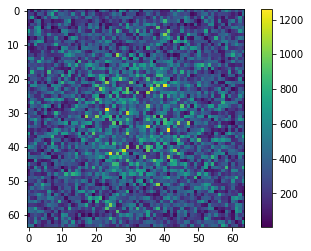

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f_cropped[124]))); plt.colorbar()



In [12]:
imgs_f_cropped.shape

(39972, 64, 64)

In [13]:
imgs_f = imgs_f_cropped
imgs_f = imgs_f.reshape(imgs_f.shape[0], -1)
N = imgs_f.shape[0]

In [14]:
imgs_f.shape

(39972, 4096)

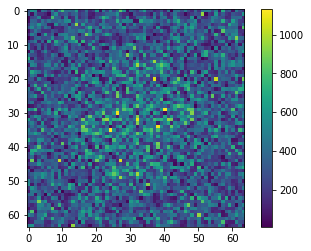

In [15]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

### Create the grids

1433.0


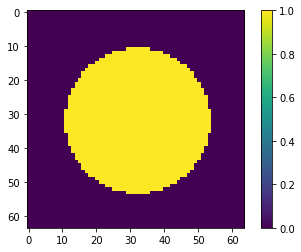

In [16]:
# Assume the pixel size is the same for all images
px = pixel_size[0]

x_freq = np.fft.fftfreq(nx, px)
y_freq = np.fft.fftfreq(nx, px)
z_freq = np.fft.fftfreq(nx, px)

# Important thast the grids are not jax (aka Tracer)  objects
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

X, Y, Z = jnp.meshgrid(x_freq,z_freq,y_freq)
mask = create_mask(X, Y, Z , (0,0,0),0.4)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

print(np.sum(mask[:,:,0]))

In [17]:
@jax.jit
def slice_func(v, angles, shifts, ctf_params):
    projection, _ = project(v, x_grid, y_grid, z_grid, angles, shifts, "tri", ctf_params)

    return projection

@jax.jit
def slice_func_array(v, angles, shifts, ctf_params):    
    return jax.vmap(slice_func, in_axes = (None, 0, 0, 0))(v, angles)

In [18]:
@jax.jit
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, shifts, ctf_params, img, alpha = 1):
    #return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    
    # With l2 regularization
    return 1/(2* nx*nx) * (alpha * l2sq(v) + l2sq(slice_func(v, angles, shifts, ctf_params) - img))
    #return 1/(2* 4096.0) * (alpha * l2sq(v) + l2sq(slice_func(v, angles, shifts, ctf_params) - img))



@jax.jit
def loss_func_batched(v, angles, shifts, ctf_params, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0, 0, 0))(v, angles, shifts, ctf_params, imgs)

@jax.jit
def loss_func_sum(v, angles, shifts, ctf_params, imgs):
    return jnp.mean(loss_func_batched(v, angles, shifts, ctf_params, imgs))

In [19]:
@jax.jit
def grad_loss_volume(v, angles, shifts, ctf_params, img):
    return jax.grad(loss_func)(v, angles, shifts, ctf_params, img)

@jax.jit
def grad_loss_volume_batched(v, angles, shifts, ctf_params, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0, 0, 0))(v, angles, shifts, ctf_params, imgs), axis=0)

@jax.jit
def grad_loss_volume_sum(v, angles, shifts, ctf_params, imgs):
    return jax.grad(loss_func_sum)(v, angles, shifts, ctf_params, imgs)



Test the functions above with a random volume

In [20]:
vf = jnp.array(np.random.randn(nx,nx,nx))

In [21]:
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(4096,)

In [22]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

1.2164804935455322
(64, 64, 64)


In [23]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

1.4780874252319336
(64, 64, 64)


### CG

In [24]:
from src.algorithm import conjugate_gradient

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 50
zero = jnp.zeros(v0.shape).astype(jnp.complex64)

Abfun = grad_loss_volume_sum(zero, angles, shifts, ctf_params, imgs_f)
Ab = - jnp.conj(Abfun)
AA = lambda vv : jnp.conj(grad_loss_volume_sum(vv, angles, shifts, ctf_params, imgs_f)) + Ab

vcg, max_iter = conjugate_gradient(AA, Ab, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.001513226843960298
Iter 1 ||r|| = 0.0003023094216498652
Iter 2 ||r|| = 0.0006151861226186917
Iter 3 ||r|| = 0.0005413901707976741
Iter 4 ||r|| = 0.00044252659498887593
Iter 5 ||r|| = 0.0003225295570730149
Iter 6 ||r|| = 0.00019483565068211846
Iter 7 ||r|| = 0.00010025274001137905
Iter 8 ||r|| = 7.51646013473426e-05
Iter 9 ||r|| = 0.00010890308105963154
Iter 10 ||r|| = 0.00015055630401172304
Iter 11 ||r|| = 0.00017285993878586364
Iter 12 ||r|| = 0.00018764974721256203
Iter 13 ||r|| = 0.00019743351328696022
Iter 14 ||r|| = 0.00020316099178551057
Iter 15 ||r|| = 0.0002052367576047614
Iter 16 ||r|| = 0.0002038344443336845
Iter 17 ||r|| = 0.000199019387045102
Iter 18 ||r|| = 0.00019079542908034385
Iter 19 ||r|| = 0.0001791110954691633
Iter 20 ||r|| = 0.00016383839483668987
Iter 21 ||r|| = 0.00014473855403969232
Iter 22 ||r|| = 0.00012147428090025652
Iter 23 ||r|| = 9.395356663527677e-05
Iter 24 ||r|| = 6.408459573835503e-05
Iter 25 ||r|| = 3.9795236479251255e-05
Iter 26 ||r

In [25]:
#for i in range(10):
#    vcg, max_iter = conjugate_gradient(AA, Ab, vcg*mask, N_iter, verbose = True)

In [26]:
#print("Final loss function = ", loss_func_sum(vcg, angles, shifts, ctf_params, imgs_f))

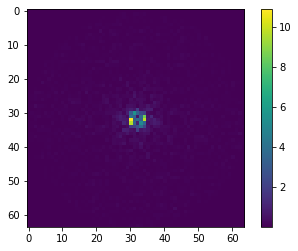

In [27]:
i = 2550
s0 = slice_func(vcg, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

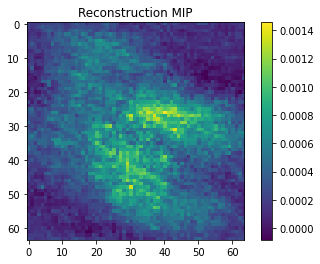

In [28]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [29]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))) 

In [30]:
vr.shape

(64, 64, 64)

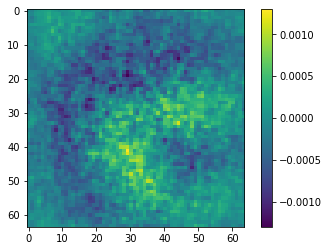

In [31]:
plt.imshow(vr[:,:,32]); plt.colorbar()

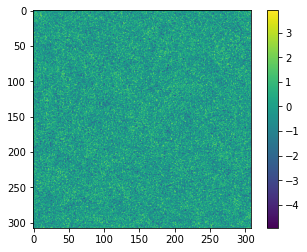

In [32]:
plt.imshow(imgs[i]); plt.colorbar()

### Write volume to file

In [38]:
with mrcfile.new('../data/reconstruction_c.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

In [34]:

vcg_pad = jnp.fft.ifftshift(jnp.pad(jnp.fft.fftshift(vcg), 64+32))

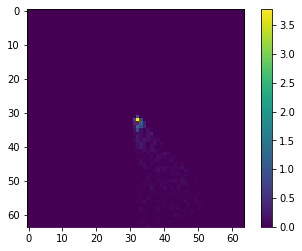

In [35]:
i = 1550
s0 = slice_func(vcg_pad, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

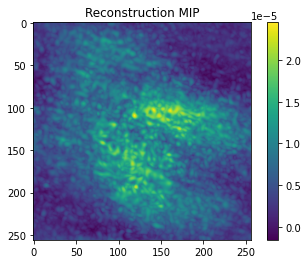

In [36]:
vr_pad = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg_pad))) 
mip_z(vr_pad)
plt.colorbar()
plt.title('Reconstruction MIP')

In [37]:
#with mrcfile.new('../data/reconstruction_pad.mrc', overwrite=True) as mrc:
#    mrc.set_data(vr_pad.astype(np.float32))